In [1]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import numpy as np 
import math
import scipy as sp
from scipy import special # must explicitly import this module 
from scipy import optimize # must explicitly import this module
from scipy import spatial
from scipy import sparse
import scprep
import pandas as pd
import graphtools as gt
from scipy.linalg import svd
import phate
import magic
#import dmaps
from sklearn.decomposition import PCA, IncrementalPCA
import graphtools
import sklearn.metrics as sm
import os
import io
import sys
import tasklogger
import sklearn.cluster as sc
from scipy.spatial.distance import sqeuclidean
import sklearn

/home/mkuchroo/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
import warnings
import time
warnings.simplefilter("ignore")
from sklearn.metrics.pairwise import pairwise_distances
from joblib import Parallel, delayed

In [3]:
### Written packages

In [4]:
def build_tree(data_input, scale=1.025, landmarks=1000, partitions = None, granularity=.1, n_pca = None, decay=40, 
               gamma=1, knn=5, n_jobs=10):
    t0 = time.time()
    print_space = '  '
    N, features = data_input.shape
        
    # Computing compression features
    n_pca, partitions = get_compression_features(N, features, n_pca, partitions, landmarks)

    print("Computing Principle Components...")
    t1 = time.time()
    pca = PCA(n_components=n_pca)
    data_pca = pca.fit_transform(np.array(data_input))
    print(print_space+'Computed Principle Components in '+str(round(time.time()-t1,3))+" seconds...")
    clusters = np.arange(N)
    
    # Subsetting if required
    if partitions!=None:
        partition_clusters = subset_data(data_pca, partitions, n_jobs=n_jobs)
        data_pca = merge_clusters(data_pca, partition_clusters)
        clusters = partition_clusters
    
    X, diff_op, diff_pca = compute_diffusion_potential(data_pca, N, decay, gamma, knn, landmarks, n_jobs)
    
    epsilon, merge_threshold = compute_condensation_param(X, granularity=granularity)
    
    NxTs, Xs, Ks, Merges, Ps = condense(X, clusters, scale,epsilon, merge_threshold, n_jobs)
    
    print("Computed full Multiscale PHATE tree in "+str(round(time.time()-t0,3))+" seconds...")
    return NxTs, Xs, Ks, Merges, Ps, diff_op, data_pca, pca, clusters, diff_pca, epsilon, merge_threshold

In [ ]:
def get_compression_features(N, features, n_pca, partitions, landmarks):
    if n_pca == None:
        n_pca = min(N, features)
    if n_pca > 100:
        n_pca = 100
    
   # if N<100000:
   #     partitions=None
    
    if partitions != None and partitions>=N:
        partitions=None
    
    if partitions != None and partitions>50000:
        partitions=50000
    elif N > 100000:
        partitions=20000
    
    return n_pca, partitions

In [6]:
def cluster_components(data_subset, num_cluster, size):
    if data_subset.shape[0] == 1:
        return [0]
    k = math.ceil(data_subset.shape[0]/size)
    #print(data_subset.shape)
    #print(k)
    if k > num_cluster:
        k = num_cluster
    #print(k)
    mbk = sc.MiniBatchKMeans(init='k-means++', n_clusters=k, batch_size=k*10,
                                         n_init=10, max_no_improvement=10, verbose=0).fit(data_subset)
    return mbk.labels_

In [7]:
def subset_data(data, desired_num_clusters, n_jobs, num_cluster = 100):
    N = data.shape[0]
    size = int(N/desired_num_clusters)
    print_space = '  '
    print('Computing Partitions...')
    t0 = time.time()

    mbk = sc.MiniBatchKMeans(init='k-means++', n_clusters=num_cluster, batch_size=num_cluster*10,
                              n_init=10, max_no_improvement=10, verbose=0).fit(data)

    clusters = mbk.labels_
    clusters_unique, cluster_counts = np.unique(clusters, return_counts=True)
    clusters_next_iter = clusters.copy()
    
    while np.max(cluster_counts) > math.ceil(N/desired_num_clusters):
        min_val = 0
        partitions_id_uni=Parallel(n_jobs=n_jobs)(delayed(cluster_components)(data[np.where(clusters == clusters_unique[i])[0],:],
                                                                                num_cluster, size) for i in range(len(clusters_unique)))

        for i in range(len(clusters_unique)):
            loc = np.where(clusters == clusters_unique[i])[0]
            clusters_next_iter[loc] = np.array(partitions_id_uni[i]) + min_val
            min_val = min_val + np.max(np.array(partitions_id_uni[i])) + 1

        clusters = clusters_next_iter.copy()
        clusters_unique, cluster_counts = np.unique(clusters, return_counts=True)

    print(print_space+"Computed Partitions in "+str(round(time.time() - t0,3))+" seconds...")
    return clusters

In [8]:
from collections import defaultdict 
  
#merge function to  merge all sublist having common elements. 
def merge_common(lists): 
    neigh = defaultdict(set) 
    visited = set() 
    for each in lists: 
        for item in each: 
            neigh[item].update(each) 
    def comp(node, neigh = neigh, visited = visited, vis = visited.add): 
        nodes = set([node]) 
        next_node = nodes.pop 
        while nodes: 
            node = next_node() 
            vis(node) 
            nodes |= neigh[node] - visited 
            yield node 
    for node in neigh: 
        if node not in visited: 
            yield sorted(comp(node))

In [9]:
def compute_diffusion_potential(data, N, decay, gamma, knn, landmarks=2000, n_jobs=10):
    print("Computing Diffusion Potential...")
    print_space = '  '
    t0 = time.time()
    
    if landmarks != None and landmarks > data.shape[0]:
        landmarks = None
    diff_op = phate.PHATE(verbose=False, n_landmark=landmarks, n_pca = None,
                          decay=decay, gamma=gamma, knn=knn, n_jobs=n_jobs)
    _ = diff_op.fit(data)

   # print("Performing PCA on Diffusion Potential...")
    pca = PCA(n_components=25)
    diff_potential_pca = pca.fit_transform(diff_op.diff_potential)
    
    print(print_space+"Computed Diffusion Potential in "+str(round(time.time() - t0,3))+" seconds...")
        
    return diff_potential_pca[:,pca.explained_variance_/np.sum(pca.explained_variance_)>.01], diff_op, pca

In [10]:
def scale_down(ideal):
    ideal_list = ideal.copy()
    list = np.unique(ideal)
    list_match = range(0,len(list),1)
    
    for r in range(0,len(ideal_list)):
        ideal_list[r] = list_match[np.where(ideal_list[r]==list)[0][0]]
        
    return np.array(ideal_list)

In [11]:
def merge_clusters(diff_pot_unmerged, clusters):
    clusters_uni = np.unique(clusters)
    num_clusters = len(clusters_uni)
    diff_pot_merged = np.zeros(num_clusters * diff_pot_unmerged.shape[1]).reshape(
        num_clusters, diff_pot_unmerged.shape[1])
    
    for c in range(num_clusters):
        loc = np.where(clusters_uni[c] == clusters)[0]
        diff_pot_merged[c,:] = np.nanmean(diff_pot_unmerged[loc], axis=0)
        
    return diff_pot_merged

In [12]:
def repulsion(temp):
    for r in range(temp.shape[0]):
        for c in range(temp.shape[1]):
            val = temp[r,c]
            neg = val < 0
            if neg:
                temp[r,c] = -1 * np.sqrt(np.abs(val))
            else:
                temp[r,c] = np.sqrt(val)
    return temp

In [13]:
def get_clusters_sizes(clusters_full, layer, NxT, X, repulse=False):
    clusters_unique = np.unique(clusters_full)
    clusters = np.zeros(len(X[layer])).astype(int)
    sizes = np.zeros(len(X[layer]))
    
    for i in range(len(clusters)):
        loc = np.where(i==scale_down(NxT[layer]))[0]
        sizes[i] = len(loc)
        clusters[i] = clusters_full[loc][0]
    if repulse:
        embedding = phate.mds.embed_MDS(repulsion(X[layer].copy()))
    else:
        embedding = phate.mds.embed_MDS(X[layer])
    return embedding, clusters, sizes

In [109]:
def compute_condensation_param(X, granularity):
    epsilon=granularity*(.1*np.mean(np.std(X)))/(X.shape[0]**(-1/5))
    D = spatial.distance.pdist(X, metric='euclidean')
    merge_threshold = np.percentile(D, .001) + .001
    print("Setting epsilon to "+str(round(epsilon,4)))
    print("Setting merge threshold to "+str(round(merge_threshold,4)))
    return epsilon, merge_threshold

In [15]:
def condense(X, clusters, scale, epsilon, merge_threshold, n_jobs):
    print_space = '  '
    NxT = []; NxT.append(clusters); NxT.append(clusters)
    X_cont = []
    
    N = X.shape[0]
    
    for c in range(len(np.unique(clusters))):
        loc = np.where(c == clusters)[0]
        X_cont.append(list(loc))
    X_1 = X.copy()
    K_list = []
    X_list = []; X_list.append(X_1); X_list.append(X_1)
    P_list = []
    merged = []
    t0=time.time()
    print("Condensing data...")
    while X_1.shape[0] > 1:
        D = pairwise_distances(X_1, metric = 'euclidean', n_jobs = n_jobs)
        bool_ = D < merge_threshold
        loc = np.where(bool_)
        merge_pairs = []
        for i in range(len(loc[0])):
            if loc[0][i] != loc[1][i]:
                merge_pairs.append(tuple([loc[0][i],loc[1][i]])) 

        while len(merge_pairs) == 0:
            epsilon = scale*epsilon
            tm = time.time()
            G = gt.Graph(X_1, bandwidth=epsilon, n_jobs=n_jobs)
            
            P_s = G.P.toarray()            
            X_2 = P_s @ X_1
            
            X_1 = X_2
            X_list.append(X_1)
            P_list.append(P_s)
            NxT.append(NxT[-1].copy())
            K_list.append(G.K.toarray())
            
            D = pairwise_distances(X_1, metric = 'euclidean', n_jobs = n_jobs)
            bool_ = D < merge_threshold
            loc = np.where(bool_)
            merge_pairs = []
            for i in range(len(loc[0])):
                if loc[0][i] != loc[1][i]:
                    merge_pairs.append(tuple([loc[0][i],loc[1][i]])) 
                    
        merge_pairs = list(merge_common(merge_pairs))        
        merged.append(merge_pairs)
        
        cluster_assignment = NxT[-1].copy()

        tm = time.time()
        to_delete =  []
        for m in range(len(merge_pairs)):
            to_merge = merge_pairs[m]
            X_1[to_merge[0]] = np.mean(X_1[to_merge], axis=0)
            to_delete.extend(to_merge[1:])
            for c in range(1,len(to_merge)):
                X_cont[to_merge[0]].extend(X_cont[to_merge[c]])
                cluster_assignment[X_cont[to_merge[c]]] = cluster_assignment[X_cont[to_merge[0]]][0]

        X_1 = np.delete(X_1, to_delete, axis=0)
        X_cont = list(np.delete(X_cont, to_delete, axis=0))
        
        del(X_list[-1])
        X_list.append(X_1)

        del NxT[-1]
        NxT.append(cluster_assignment)
    
    print(print_space+"Condensed data in "+str(round(time.time() - t0,3))+" seconds...")
    return NxT, X_list, K_list, merged, P_list


In [16]:
def compute_gradient(Xs, merges):
    gradient = []
    m = 0
    X = Xs[0]

    for l in range(0,len(Xs)-1):
        if X.shape[0] != Xs[l+1].shape[0]:
            X_1 = condense_visualization(merges[m], X)
            m = m+1
            while X_1.shape[0] != Xs[l+1].shape[0]:
                X_1 = condense_visualization(merges[m], X_1)
                m = m+1
        else:
            X_1 = X
        gradient.append(np.sum(np.abs(X_1 - Xs[l+1])))
        X = Xs[l+1]
    return np.array(gradient)

In [17]:
def compute_ideal_visualization_layer(gradient, Xs, min_cells = 100):
    minimum = np.max(gradient)
    min_layer = 0

    for l in range(1,len(Xs)):
        if Xs[l].shape[0] < min_cells:
            break
        if gradient[l] < minimum:
            #print("New minimum!")
            minimum = gradient[l]
            min_layer = l
    return min_layer

In [18]:
def condense_visualization(merge_pairs, phate):
    to_delete = []
    for m in range(len(merge_pairs)):
        to_merge = merge_pairs[m]
        phate[to_merge[0]] = np.mean(phate[to_merge], axis=0)
        to_delete.extend(to_merge[1:])
    phate = np.delete(phate, to_delete, axis=0)
    return phate

In [19]:
def get_clusters_sizes_2(clusters_full, layer, NxT, X, repulse=False, n_jobs=10):
    unique = np.unique(NxT[layer], return_index=True, return_counts=True)
    
    #expand_X = Xs[layer][scale_down(NxTs[layer])]
    #subset_X = expand_X[np.unique(NxTs[layer], return_index=True)[1]]
    
    subset_X = X[layer]
    
    if repulse:
        embedding = phate.mds.embed_MDS(repulsion(subset_X.copy()), n_jobs=n_jobs)
    else:
        embedding = phate.mds.embed_MDS(subset_X,  n_jobs=n_jobs)
    return embedding, clusters_full[unique[1]], unique[2]

In [20]:
def get_clusters(clusters_full, layer, NxT):
    unique = np.unique(NxT[layer], return_index=True, return_counts=True)
    
    #expand_X = Xs[layer][scale_down(NxTs[layer])]
    #subset_X = expand_X[np.unique(NxTs[layer], return_index=True)[1]]
    
    return clusters_full[unique[1]]

In [21]:
def get_clusters_size(clusters_full, layer, NxT):
    unique = np.unique(NxT[layer], return_index=True, return_counts=True)
    
    #expand_X = Xs[layer][scale_down(NxTs[layer])]
    #subset_X = expand_X[np.unique(NxTs[layer], return_index=True)[1]]
    
    return clusters_full[unique[1]], unique[2]

In [22]:
def build_condensation_tree(data_pca, diff_op, NxT, merged_list, Ps):
    print_space = '  '
    print("Computing base visualization...")
    t0 = time.time()
    tree_phate = diff_op.transform(data_pca)
    print(print_space+'Computed base visualization in '+str(round(time.time() - t0,3))+" seconds...")
    
    #tree_phate = Ps[0] @ tree_phate
    embeddings = []; embeddings.append(np.concatenate([tree_phate, np.repeat(0,tree_phate.shape[0]).reshape(tree_phate.shape[0],1)], axis=1))
    
    m=0

    print("Computing tree...")
    t0 = time.time()
    for l in range(0,len(Ps)):
        if len(np.unique(NxT[l])) != len(np.unique(NxT[l+1])):
            tree_phate_1 = condense_visualization(merged_list[m], tree_phate)
            m=m+1
        if Ps[l].shape[0] != tree_phate_1.shape[0]:
            tree_phate_1 = condense_visualization(merged_list[m], tree_phate_1)
            m=m+1
        tree_phate = Ps[l] @ tree_phate_1
        embeddings.append(np.concatenate([tree_phate, np.repeat(l+1,tree_phate.shape[0]).reshape(tree_phate.shape[0],1)], axis=1))
        
    tree = np.vstack((embeddings))
    print(print_space+'Computed tree in '+str(round(time.time() - t0,3))+" seconds...")

    return tree

In [23]:
def get_expression(expression, layer, NxT):
    
    clust_unique = np.unique(np.array(NxT[layer]))
    loc = []
    for c in clust_unique:
        loc.append(np.where(np.array(NxT[layer]) == c)[0])
        
    exp = []
    for l in loc:
        exp.append(np.mean(expression[l]))
    return np.array(exp)

In [63]:
def online_update(data_1, data_2, pca_centroid, partitions, diff_operator, diff_pca_op,
                  Xs, Ks, Merges, Ps, scale, n_jobs=10):
    t0 = time.time()
    if data_1.shape[0] != len(np.unique(partitions)):
        print('PCA Compressing new data...')
        data_pca_1 = pca.transform(np.array(data_1))
        data_pca_2 = pca.transform(np.array(data_2))

        # Mapping new data to partitions
        partition_assignments = map_update_data(pca_centroid, data_pca_1, data_pca_2, partitions, nn=5, n_jobs=n_jobs)
        print("Points not mapped to partitions: "+str(sum(partition_assignments==-1)))

        # creating new joint paritions mapping
        new_partition_clusters = list(partitions)

        new_partition_clusters.extend(partition_assignments)
        new_partition_clusters = np.asarray(new_partition_clusters)

        update_idx = np.where(new_partition_clusters==-1)[0]

        max_partition = max(new_partition_clusters)

        for i in range(len(update_idx)):
            new_partition_clusters[update_idx[i]] = max_partition+1
            max_partition+=1

        if sum(partition_assignments==-1) > 0:
            diff_pot_1 = build_new_diffusion_potential(data_pca_2[partition_assignments==-1,:], diff_operator, diff_pca_op)
            epsilon, merge_threshold = compute_condensation_param(diff_pot_1, granularity=.1) # change to granularity

            pca_total = np.concatenate([pca_centroid, data_pca_2[partition_assignments==-1,:]])
            
            NxTs_n, Xs_n, Ks_n, Merges_n, Ps_n = condense(diff_pot_1, new_partition_clusters, scale, epsilon, merge_threshold, n_jobs=n_jobs)
            print("Computed Multiscale PHATE tree mapping in "+str(round(time.time()-t0,3))+" seconds...")
            return NxTs_n, Xs_n, Ks_n, Merges_n, Ps_n, pca_total

        else:
            clusters = new_partition_clusters
            print("Rebuilding condensation tree...")
            clusters_idx = []

            for c in clusters:
                clusters_idx.append(np.where(NxTs[0]==c)[0][0])

            NxTs_l = []

            for l in range(len(NxTs)):
                NxTs_l.append(NxTs[l][clusters_idx])
            print("Computed Multiscale PHATE tree mapping in "+str(round(time.time()-t0,3))+" seconds...")
            return NxTs_l, Xs, Ks, Merges, Ps, data_pca

    else:
        print('PCA Compressing new data...')
        data_pca_2 = pca.transform(np.array(data_2))
        diff_pot_1 = build_new_diffusion_potential(data_pca_2, diff_operator, diff_pca_op)
        clusters = np.arange(diff_pot_1.shape[0])

        epsilon, merge_threshold = compute_condensation_param(diff_pot_1, granularity=.1) # change to granularity

        NxTs_n, Xs_n, Ks_n, Merges_n, Ps_n = condense(diff_pot_1, clusters, scale, epsilon, merge_threshold, n_jobs=n_jobs)
        print("Computed Multiscale PHATE tree mapping in "+str(round(time.time()-t0,3))+" seconds...")
        return NxTs_n, Xs_n, Ks_n, Merges_n, Ps_n, np.concatenate([pca_centroid, data_pca_2])


In [25]:
def build_new_diffusion_potential(unmapped_data, diff_op, dp_pca):
    print_space = '  '
    print("Computing new Diffusion Potential...")
    t0=time.time()
    # Extending kernel to new data
    transitions = diff_op.graph.extend_to_data(unmapped_data)
    print(print_space+'Built kernel in '+str(round(time.time()-t0,3))+" seconds...")

    merged_dp = merge_clusters(diff_op.diff_potential, diff_op.graph.clusters)
    
    dp_full = np.concatenate((diff_op.diff_potential, (transitions.toarray() @ merged_dp)), axis=0)
    
    new_diff_potential_pca = dp_pca.transform(dp_full)
    
    print(print_space+"Computed extended Diffusion Potential in "+str(round(time.time()-t0,3))+" seconds...")
    
    return new_diff_potential_pca[:,dp_pca.explained_variance_/np.sum(dp_pca.explained_variance_)>.01]

In [26]:
def map_update_data(centroids, data, new_data, partition_clusters, nn=5, n_jobs=10):
    print_space = '  '
    print('Mapping new data to computed partitions...')
    t0 = time.time()
    # getting max distance to each partition centroid
    distance_merged = get_distance_from_centroids(centroids, data, partition_clusters)
    
    # Mapping NN in new data to centroids
    NN_op = sklearn.neighbors.NearestNeighbors(n_neighbors=nn, n_jobs=n_jobs)
    NN_op.fit(centroids)
    neighbor_dists, neighbor_idx = NN_op.kneighbors(new_data)
    
    # Identifying which new data points fall below threshold
    parition_assignment_bool = neighbor_dists < distance_merged[neighbor_idx]
    
    subset_partition_assignment = np.zeros(new_data.shape[0])
    subset_partition_assignment[subset_partition_assignment==0] = -1
    
    # Finding neatest mapped partition centroid
    for r in range(len(subset_partition_assignment)):
        c = 0
        while c<nn:
            if parition_assignment_bool[r,c] == True:
                subset_partition_assignment[r] = neighbor_idx[r,c]
                c = nn+1
                break
            else:
                c+=1
    print(print_space+"Computed mapping in "+str(round(time.time()-t0,3))+" seconds...")
    return subset_partition_assignment

In [27]:
def get_distance_from_centroids(centroids, data, clusters):
    distance = np.zeros(centroids.shape[0])

    for c in range(centroids.shape[0]):
        cluster_points = data[clusters==c]
        dist = []
        
        for i in range(cluster_points.shape[0]):
            dist.append(sqeuclidean(centroids[c,:], cluster_points[i,:]))
        distance[c] = np.max(dist)
    return distance

In [28]:
### Downloading data

In [29]:
path ="/home/mkuchroo/data/condensation_test_sc/"

In [30]:
amd_phate = pd.read_pickle(path+"amd_phate.pickle")
csf_phate = pd.read_pickle(path+"csf_phate.pickle")
pbmc_phate = pd.read_pickle(path+"pbmc_phate.pickle")

amd_sqrt = pd.read_pickle(path+"amd_sqrt.pickle")
csf_sqrt = pd.read_pickle(path+"csf_sqrt.pickle")
pbmc_sqrt = pd.read_pickle(path+"pbmc_sqrt.pickle")

In [ ]:
### PBMC Compression without partitions

In [52]:
pbmc_sqrt_1 = pbmc_sqrt.iloc[:3000,:]
pbmc_sqrt_2 = pbmc_sqrt.iloc[3000:,:]

In [53]:
NxTs,Xs,Ks,merges,Ps,diff_op,data_pca,pca,partition_clusters,dp_pca,epsilon,merge_threshold = build_tree(pbmc_sqrt_1,
                                                                                                         n_jobs=10)

Computing Principle Components...
  Computed Principle Components in 1.797 seconds...
Computing Diffusion Potential...
  Computed Diffusion Potential in 8.922 seconds...
Setting epsilon to 2.7944
Setting merge threshold to 0.115
Condensing data...
  Condensed data in 6.026 seconds...
Computed full Multiscale PHATE tree in 16.815 seconds...


In [54]:
len(NxTs)

164

In [55]:
gradient = compute_gradient(Xs, merges)

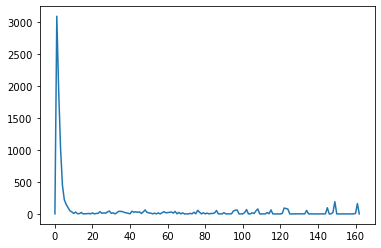

In [56]:
plt.plot(gradient)

In [57]:
min_layer = compute_ideal_visualization_layer(gradient, Xs, min_cells = 1000)

In [58]:
hp_embedding, cluster_viz, sizes_viz = get_clusters_sizes_2(np.array(NxTs[-35]), min_layer, NxTs, Xs, repulse=False)

In [59]:
hp_embedding.shape

(1709, 2)

<AxesSubplot:xlabel='Multiscale-PHATE1', ylabel='Multiscale-PHATE2'>

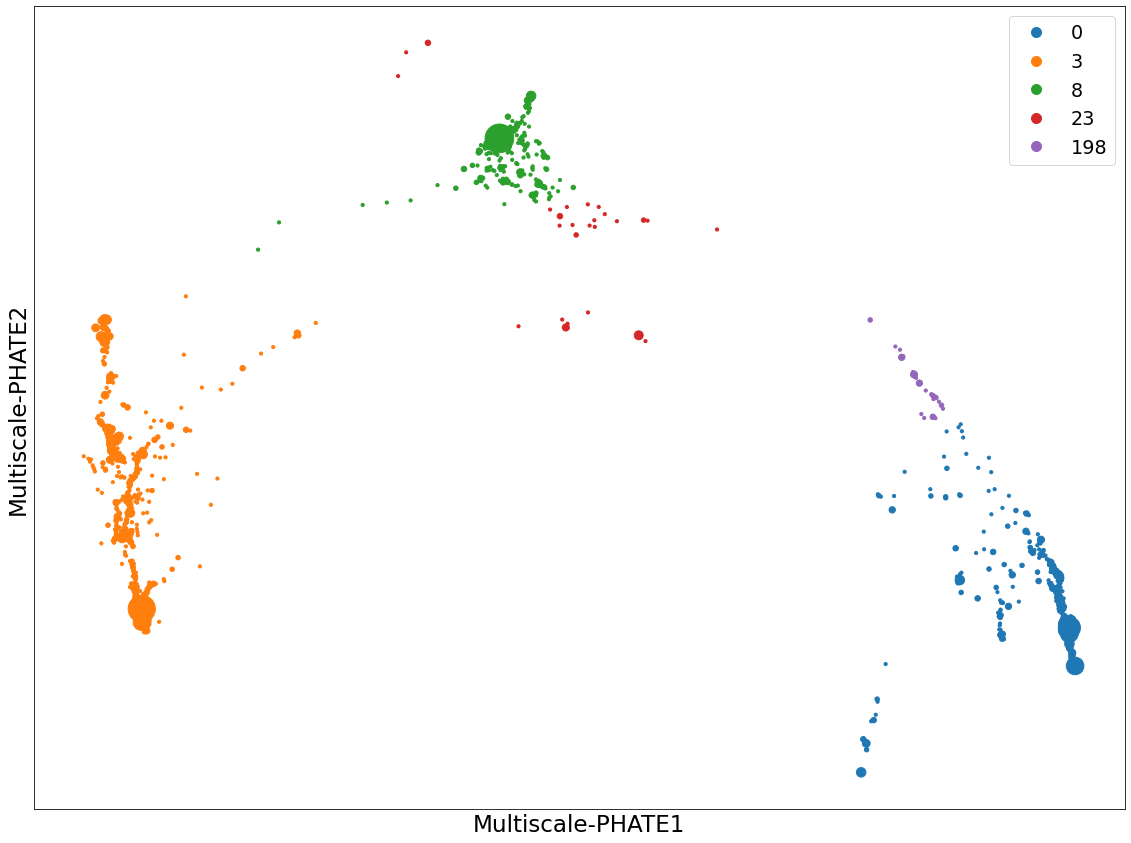

In [60]:
scprep.plot.scatter2d(hp_embedding, s = 10*sizes_viz, c = cluster_viz,
                      fontsize=16, ticks=False,label_prefix="Multiscale-PHATE", figsize=(16,12))

In [ ]:
## Updating

In [64]:
NxTs_1, Xs_1, Ks_1, Merges_1, Ps_1, data_pca_l = online_update(pbmc_sqrt_1, pbmc_sqrt_2, data_pca,
                                                   partition_clusters, diff_op, dp_pca, Xs, Ks, merges, Ps, 1.025, 10)

PCA Compressing new data...
Computing new Diffusion Potential...
  Built kernel in 0.686 seconds...
  Computed extended Diffusion Potential in 0.886 seconds...
Setting epsilon to 3.01
Setting merge threshold to 0.1172
Condensing data...
  Condensed data in 7.421 seconds...
Computed Multiscale PHATE tree mapping in 9.03 seconds...


In [65]:
len(np.unique(NxTs_1[0]))

4342

In [66]:
gradient_1 = compute_gradient(Xs_1, Merges_1)

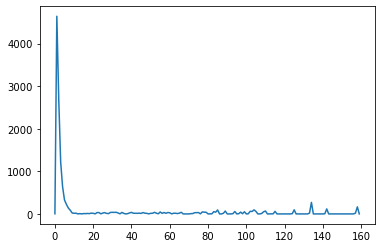

In [67]:
plt.plot(gradient_1)

In [68]:
min_layer_1 = compute_ideal_visualization_layer(gradient_1, Xs_1, min_cells = 1000)

In [69]:
hp_embedding_1, cluster_viz_1, sizes_viz_1 = get_clusters_sizes_2(np.array(NxTs_1[-35]), min_layer_1,
                                                                  NxTs_1, Xs_1, repulse=False)

In [70]:
hp_embedding_1.shape

(1047, 2)

<AxesSubplot:xlabel='Multiscale-PHATE1', ylabel='Multiscale-PHATE2'>

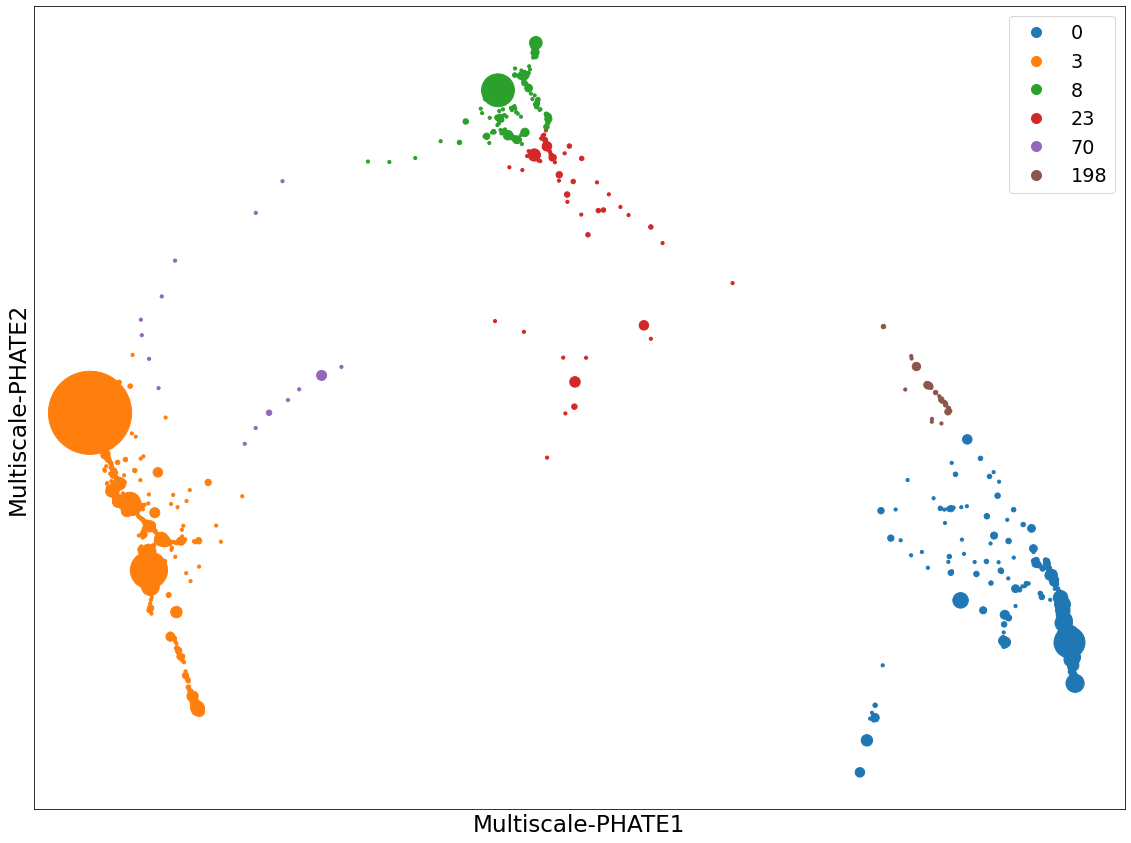

In [71]:
scprep.plot.scatter2d(hp_embedding_1, s = 10*sizes_viz_1, c = cluster_viz_1,
                      fontsize=16, ticks=False,label_prefix="Multiscale-PHATE", figsize=(16,12))

In [75]:
tree = build_condensation_tree(data_pca_l, diff_op, NxTs_1, Merges_1, Ps_1)

Computing base visualization...
  Computed base visualization in 2.129 seconds...
Computing tree...
  Computed tree in 0.146 seconds...


<Axes3DSubplot:xlabel='C-PHATE1', ylabel='C-PHATE2'>

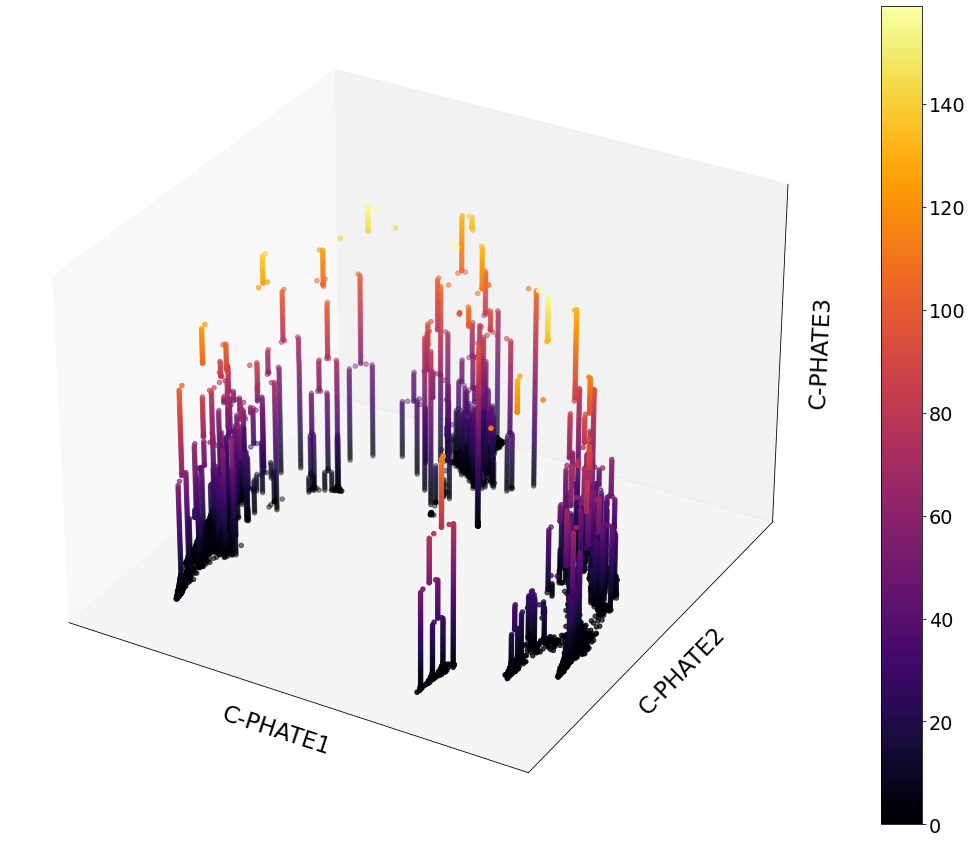

In [76]:
scprep.plot.scatter3d(tree, c=tree[:,2],fontsize=16, ticks=False, label_prefix="C-PHATE", figsize=(16,12), s=20)

In [ ]:
### PBMC Compression with partitions

In [52]:
pbmc_sqrt_1 = pbmc_sqrt.iloc[:3000,:]
pbmc_sqrt_2 = pbmc_sqrt.iloc[3000:,:]

In [77]:
NxTs,Xs,Ks,merges,Ps,diff_op,data_pca,pca,partition_clusters,dp_pca,epsilon,merge_threshold = build_tree(pbmc_sqrt_1,
                                                                                                         partitions=1000,
                                                                                                         n_jobs=10)

Computing Principle Components...
  Computed Principle Components in 1.859 seconds...
Computing Partitions...
  Computed Partitions in 8.212 seconds...
Computing Diffusion Potential...
  Computed Diffusion Potential in 5.508 seconds...
Setting epsilon to 1.7088
Setting merge threshold to 0.0339
Condensing data...
  Condensed data in 4.513 seconds...
Computed full Multiscale PHATE tree in 20.241 seconds...


In [78]:
len(NxTs)

161

In [79]:
gradient = compute_gradient(Xs, merges)

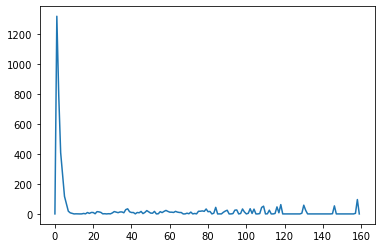

In [80]:
plt.plot(gradient)

In [81]:
min_layer = compute_ideal_visualization_layer(gradient, Xs, min_cells = 1000)

In [82]:
hp_embedding, cluster_viz, sizes_viz = get_clusters_sizes_2(np.array(NxTs[-35]), min_layer, NxTs, Xs, repulse=False)

In [83]:
hp_embedding.shape

(1099, 2)

<AxesSubplot:xlabel='Multiscale-PHATE1', ylabel='Multiscale-PHATE2'>

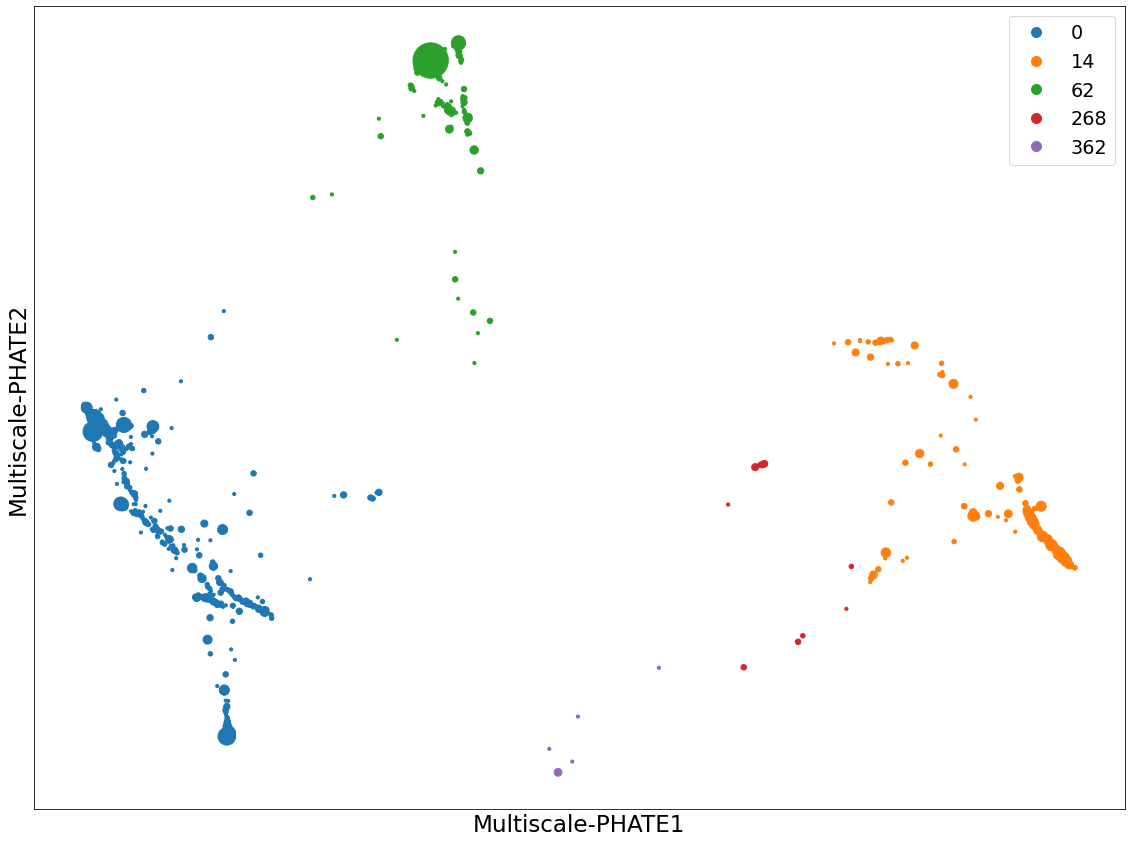

In [84]:
scprep.plot.scatter2d(hp_embedding, s = 10*sizes_viz, c = cluster_viz,
                      fontsize=16, ticks=False,label_prefix="Multiscale-PHATE", figsize=(16,12))

In [ ]:
## Updating

In [85]:
NxTs_1, Xs_1, Ks_1, Merges_1, Ps_1, data_pca_l = online_update(pbmc_sqrt_1, pbmc_sqrt_2, data_pca,
                                                   partition_clusters, diff_op, dp_pca, Xs, Ks, merges, Ps, 1.025, 10)

PCA Compressing new data...
Mapping new data to computed partitions...
  Computed mapping in 0.207 seconds...
Points not mapped to partitions: 0
Rebuilding condensation tree...
Computed Multiscale PHATE tree mapping in 1.546 seconds...


In [86]:
len(np.unique(NxTs_1[0]))

2043

In [87]:
gradient_1 = compute_gradient(Xs_1, Merges_1)

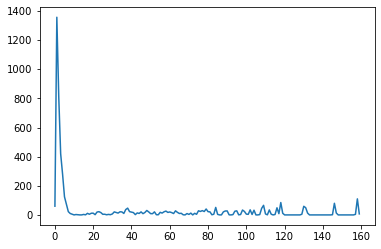

In [88]:
plt.plot(gradient_1)

In [89]:
min_layer_1 = compute_ideal_visualization_layer(gradient_1, Xs_1, min_cells = 1000)

In [90]:
hp_embedding_1, cluster_viz_1, sizes_viz_1 = get_clusters_sizes_2(np.array(NxTs_1[-35]), min_layer_1,
                                                                  NxTs_1, Xs_1, repulse=False)

In [91]:
hp_embedding_1.shape

(1099, 2)

<AxesSubplot:xlabel='Multiscale-PHATE1', ylabel='Multiscale-PHATE2'>

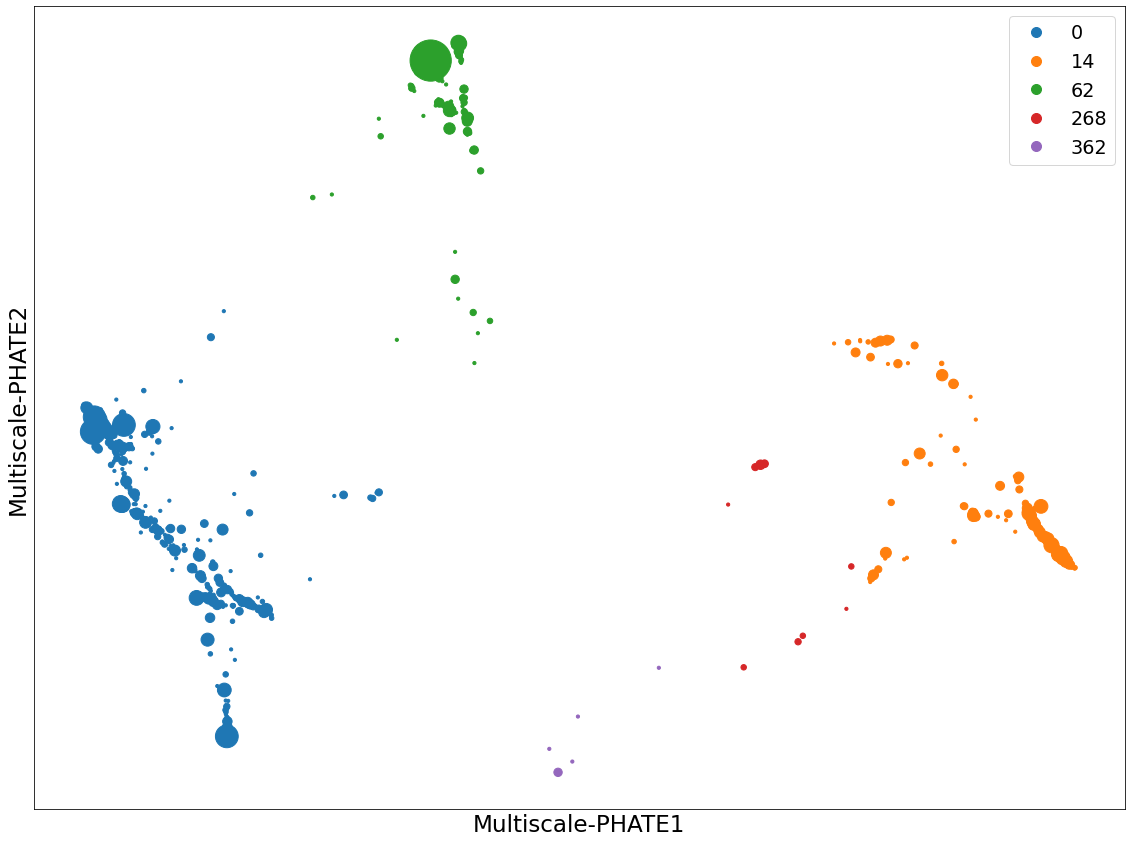

In [92]:
scprep.plot.scatter2d(hp_embedding_1, s = 10*sizes_viz_1, c = cluster_viz_1,
                      fontsize=16, ticks=False,label_prefix="Multiscale-PHATE", figsize=(16,12))

In [93]:
tree = build_condensation_tree(data_pca_l, diff_op, NxTs_1, Merges_1, Ps_1)

Computing base visualization...
  Computed base visualization in 0.871 seconds...
Computing tree...
  Computed tree in 0.062 seconds...


<Axes3DSubplot:xlabel='C-PHATE1', ylabel='C-PHATE2'>

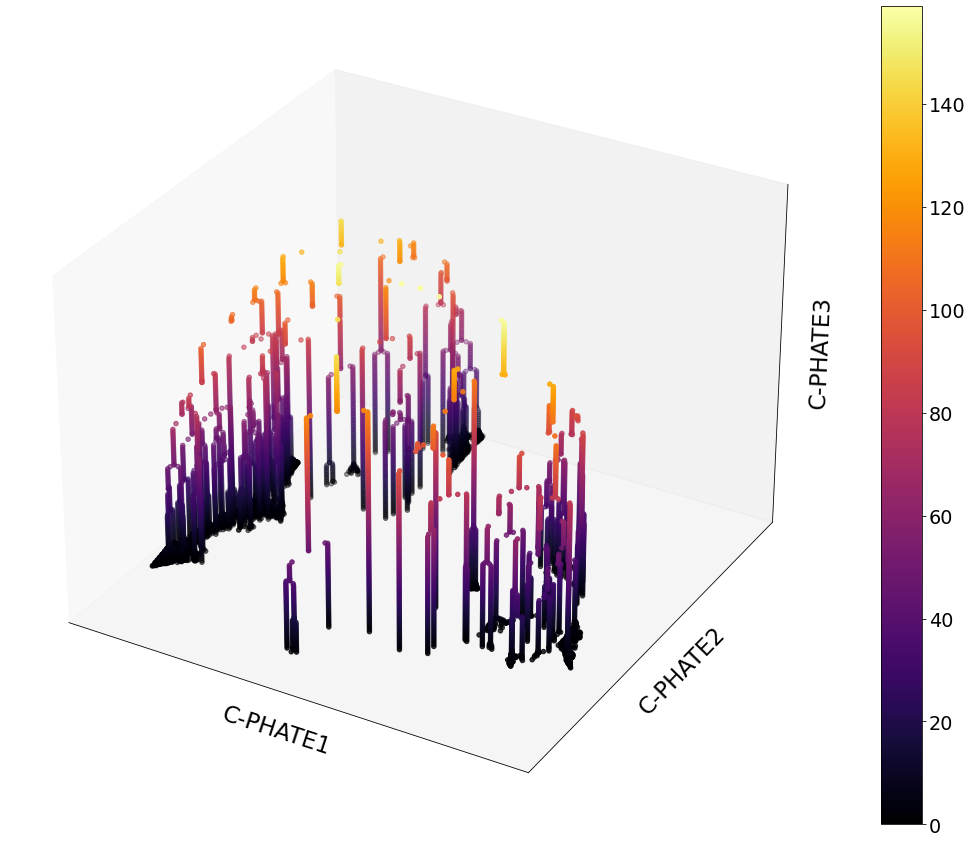

In [94]:
scprep.plot.scatter3d(tree, c=tree[:,2],fontsize=16, ticks=False, label_prefix="C-PHATE", figsize=(16,12), s=20)

In [105]:
### Larger dataset

path = "/data/lab/datasets/Iwasaki_covid_facs/variables/data_7_24_2020/patients_only/"
facs_sqrt = pd.read_pickle(path+"myeloid_sqrt.pickle")

In [106]:
chosen_idx = np.random.choice(facs_sqrt.shape[0], replace=False, size=2000000)

In [107]:
subset_sqrt = facs_sqrt.iloc[chosen_idx[:500000],:]
superset_sqrt = facs_sqrt.iloc[chosen_idx[500000:],:]

In [110]:
NxTs,Xs,Ks,merges,Ps,diff_op,data_pca,pca,partition_clusters,dp_pca,epsilon,merge_threshold = build_tree(superset_sqrt,
                                                                                                         partitions=20000,
                                                                                                         n_jobs=10)

Computing Principle Components...
  Computed Principle Components in 0.691 seconds...
Computing Partitions...
  Computed Partitions in 218.747 seconds...
Computing Diffusion Potential...
  Computed Diffusion Potential in 33.52 seconds...
Setting epsilon to 0.9045
Setting merge threshold to 0.001
Condensing data...
  Condensed data in 140.446 seconds...
Computed full Multiscale PHATE tree in 437.813 seconds...


In [111]:
len(NxTs)

160

In [112]:
gradient = compute_gradient(Xs, merges)

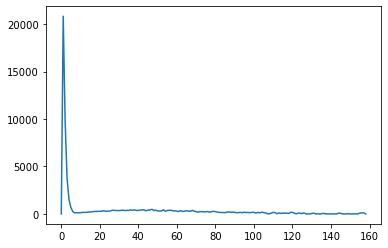

In [113]:
plt.plot(gradient)

In [114]:
min_layer = compute_ideal_visualization_layer(gradient, Xs, min_cells = 1000)

In [115]:
hp_embedding, cluster_viz, sizes_viz = get_clusters_sizes_2(np.array(NxTs[-35]), min_layer, NxTs, Xs, repulse=False)

In [116]:
hp_embedding.shape

(5727, 2)

<AxesSubplot:xlabel='Multiscale-PHATE1', ylabel='Multiscale-PHATE2'>

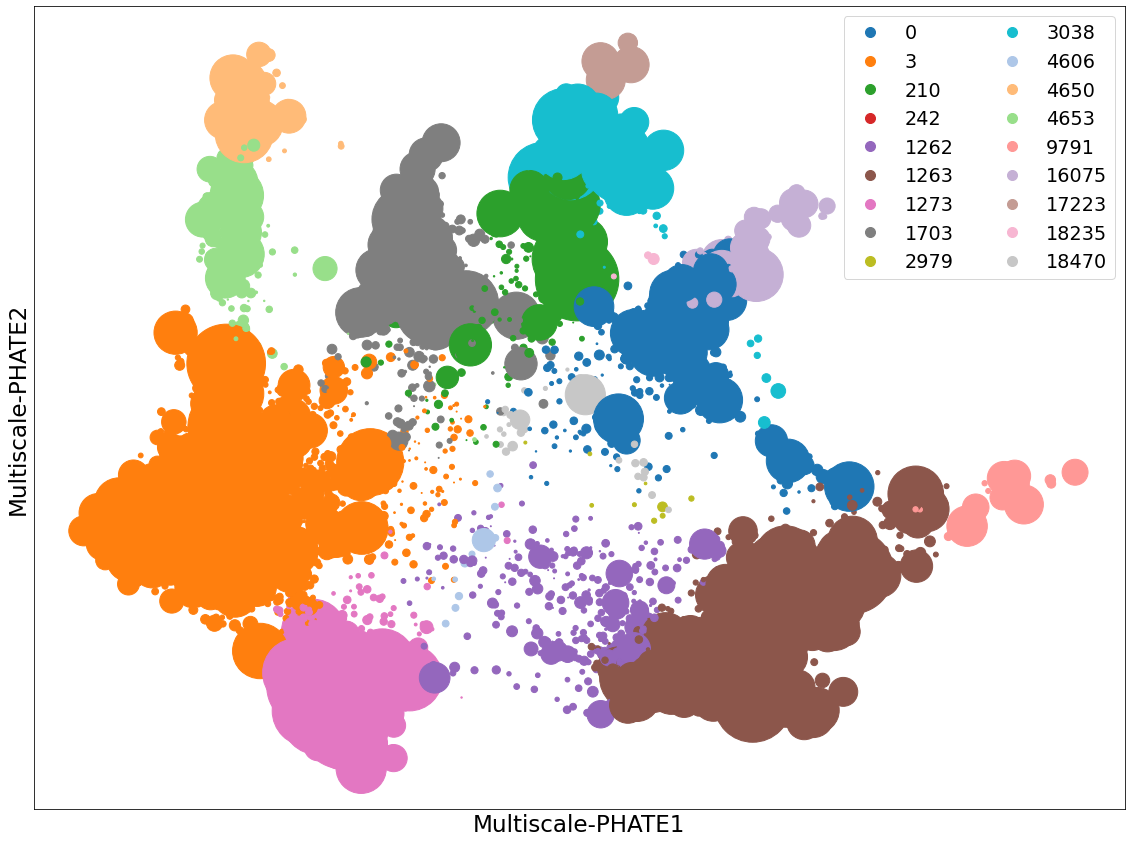

In [117]:
scprep.plot.scatter2d(hp_embedding, s = sizes_viz, c = cluster_viz,
                      fontsize=16, ticks=False,label_prefix="Multiscale-PHATE", figsize=(16,12))

In [ ]:
### updating

In [119]:
NxTs_1, Xs_1, Ks_1, Merges_1, Ps_1, data_pca_l = online_update(superset_sqrt, subset_sqrt, data_pca,
                                                   partition_clusters, diff_op, dp_pca, Xs, Ks, merges, Ps, 1.025, 10)

PCA Compressing new data...
Mapping new data to computed partitions...
  Computed mapping in 184.729 seconds...
Points not mapped to partitions: 670
Computing new Diffusion Potential...
  Built kernel in 1.002 seconds...
  Computed extended Diffusion Potential in 2.148 seconds...
Setting epsilon to 0.9051
Setting merge threshold to 0.001
Condensing data...
  Condensed data in 143.676 seconds...
Computed Multiscale PHATE tree mapping in 377.651 seconds...


In [120]:
len(np.unique(NxTs_1[0]))

39305

In [127]:
len(np.unique(NxTs[0]))

38635

In [121]:
gradient_1 = compute_gradient(Xs_1, Merges_1)

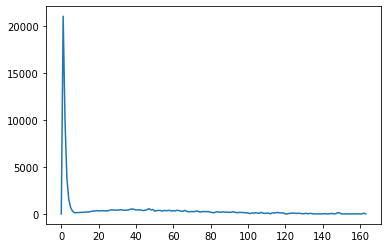

In [122]:
plt.plot(gradient_1)

In [123]:
min_layer_1 = compute_ideal_visualization_layer(gradient_1, Xs_1, min_cells = 1000)

In [124]:
hp_embedding_1, cluster_viz_1, sizes_viz_1 = get_clusters_sizes_2(np.array(NxTs_1[-35]), min_layer_1,
                                                                  NxTs_1, Xs_1, repulse=False)

In [125]:
hp_embedding_1.shape

(6216, 2)

<AxesSubplot:xlabel='Multiscale-PHATE1', ylabel='Multiscale-PHATE2'>

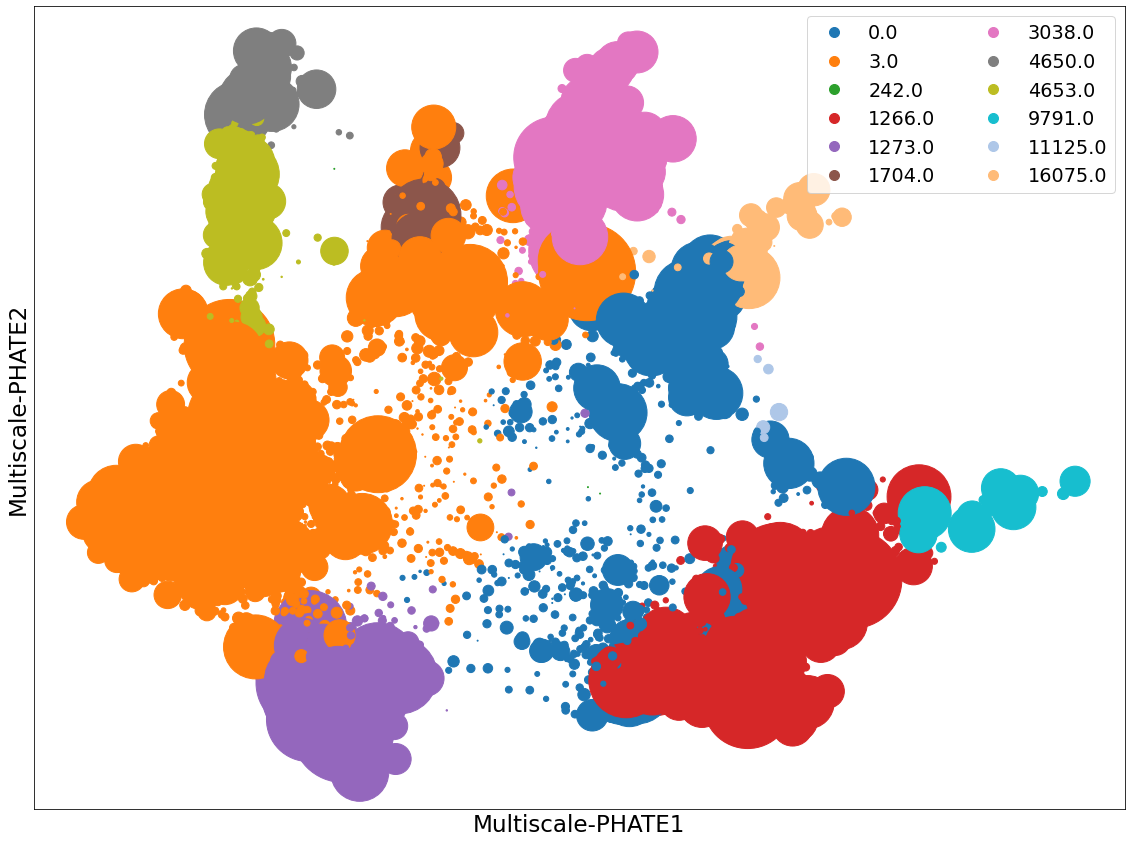

In [126]:
scprep.plot.scatter2d(hp_embedding_1, s = sizes_viz_1, c = cluster_viz_1,
                      fontsize=16, ticks=False,label_prefix="Multiscale-PHATE", figsize=(16,12))